In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3  # Import InceptionV3
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from keras.utils import to_categorical
import os

In [2]:
# Define the image size
SIZE = 256  

# Path to the dataset
dataset_path = "F:/indhu/Datasets/Tomato fruits dataset for binary and multiclass classification/Two Classes"
print(os.listdir(dataset_path))

['Healthy', 'Reject']


In [3]:
# Capture images and labels into respective lists
images = []
labels = []
for directory_path in glob.glob(dataset_path + "/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)
        labels.append(label)

In [4]:
# Convert lists to arrays        
images = np.array(images)
labels = np.array(labels)

In [5]:

# Encode labels from text to integers
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [6]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

In [7]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
# One hot encode y values for neural network (if needed later)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [9]:
# Load InceptionV3 model without fully connected layers (pretrained on ImageNet)
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [10]:
# Use the pre-trained InceptionV3 model to extract features from training images
train_features = Inception_model.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features for SVM

44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Train Random Forest on the extracted features
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees
RF_model.fit(train_features, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Extract features from testing images
test_features = Inception_model.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten features for SVM


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step


In [13]:

# Predict on test data using the Random Forest model
y_pred_rf = RF_model.predict(test_features)


In [14]:
# Inverse transform the predicted labels to their original form
y_pred_labels_rf = le.inverse_transform(y_pred_rf)

In [15]:
# Calculate accuracy of the Random Forest model
accuracy_rf = metrics.accuracy_score(le.inverse_transform(y_test), y_pred_labels_rf)
print("Random Forest Accuracy = ", accuracy_rf)

Random Forest Accuracy =  0.9458689458689459


In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Confusion matrix
cm = confusion_matrix(le.inverse_transform(y_test), y_pred_labels_rf)

# Print the confusion matrix for reference
print(f"\nConfusion Matrix:\n{cm}")

# Precision, recall, and F1 score for each class
precision_per_class = precision_score(le.inverse_transform(y_test), y_pred_labels_rf, average=None)
recall_per_class = recall_score(le.inverse_transform(y_test), y_pred_labels_rf, average=None)
f1_per_class = f1_score(le.inverse_transform(y_test), y_pred_labels_rf, average=None)

# For each class, calculate TP, FP, FN, TN
for i in range(len(cm)):
    tp = cm[i, i]  # True positives for class i
    fn = np.sum(cm[i, :]) - tp  # False negatives for class i
    fp = np.sum(cm[:, i]) - tp  # False positives for class i
    tn = np.sum(cm) - (tp + fp + fn)  # True negatives for class i
    
    print(f"\nClass {i}:\n\t")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Negatives (TN): {tn}")
    
    # Print precision, recall, and F1 score for each class
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_per_class[i]}")



Confusion Matrix:
[[318   3]
 [ 16  14]]

Class 0:
	
True Positives (TP): 318
False Positives (FP): 16
False Negatives (FN): 3
True Negatives (TN): 14
Precision: 0.9520958083832335
Recall: 0.9906542056074766
F1 Score: 0.9709923664122138

Class 1:
	
True Positives (TP): 14
False Positives (FP): 3
False Negatives (FN): 16
True Negatives (TN): 318
Precision: 0.8235294117647058
Recall: 0.4666666666666667
F1 Score: 0.5957446808510638


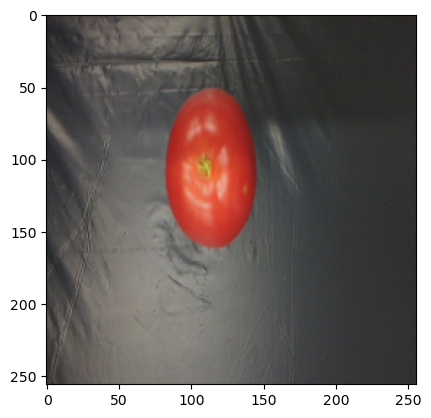

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
The prediction for this image is:  Healthy
The actual label for this image is:  Healthy


In [40]:
# Check results on a few select images
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
plt.show()

# Predict using SVM model for the selected image
input_img = np.expand_dims(img, axis=0)  # Expand dims so the input is (num images, x, y, c)
input_img_feature = Inception_model.predict(input_img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0], -1)

prediction_SVM = SVM_model.predict(input_img_feature)[0]
prediction_SVM_label = le.inverse_transform([prediction_SVM])  # Reverse the label encoder to original name

print("The prediction for this image is: ", prediction_SVM_label[0])
print("The actual label for this image is: ", le.inverse_transform([y_test[n]])[0])

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [19]:

# Calculate accuracy, precision, recall, and F1 score
accuracy_rf = metrics.accuracy_score(le.inverse_transform(y_test), y_pred_labels_rf)
precision_rf = metrics.precision_score(le.inverse_transform(y_test), y_pred_labels_rf, average='weighted')
recall_rf = metrics.recall_score(le.inverse_transform(y_test), y_pred_labels_rf, average='weighted')
f1_rf = metrics.f1_score(le.inverse_transform(y_test), y_pred_labels_rf, average='weighted')

# Create a DataFrame with the results
results_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_rf],
    'Precision': [precision_rf],
    'Recall': [recall_rf],
    'F1 Score': [f1_rf]
})

# Save results to CSV
results_rf.to_csv('results_rf.csv', index=False)
